In [246]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ripple_heterogeneity.utils import functions, loading, add_new_deep_sup, batch_analysis
from ripple_heterogeneity.assembly import (
    assembly,
    assembly_individual_epochs,
    assembly_run,
    find_sig_assembly,
    assembly_reactivation,
    assembly_react_deep_sup_ind_detect
)
from scipy import stats
import nelpy as nel
import nelpy.plotting as npl
import os
import pickle
import glob
from statannotations.Annotator import Annotator

from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [29]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")


In [ ]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_react_deep_sup_ind_detect_v2"
)
batch_analysis.run(
    df,
    save_path,
    assembly_react_deep_sup_ind_detect.run,
    parallel=True,
    verbose=True,
    num_cores=12
)

In [232]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_react_deep_sup_ind_detect_v2"
)
results_df, peth = assembly_react_deep_sup_ind_detect.load_results(save_path, verbose=False)


In [356]:
results_df = functions.add_animal_id(results_df)
results_df.animal_id.nunique()

35

In [358]:
results_df["unique_id"] = (
    results_df.assembly_n.astype(str) + results_df.deepSuperficial + results_df.basepath
)
results_df["unique_id"].nunique()

938

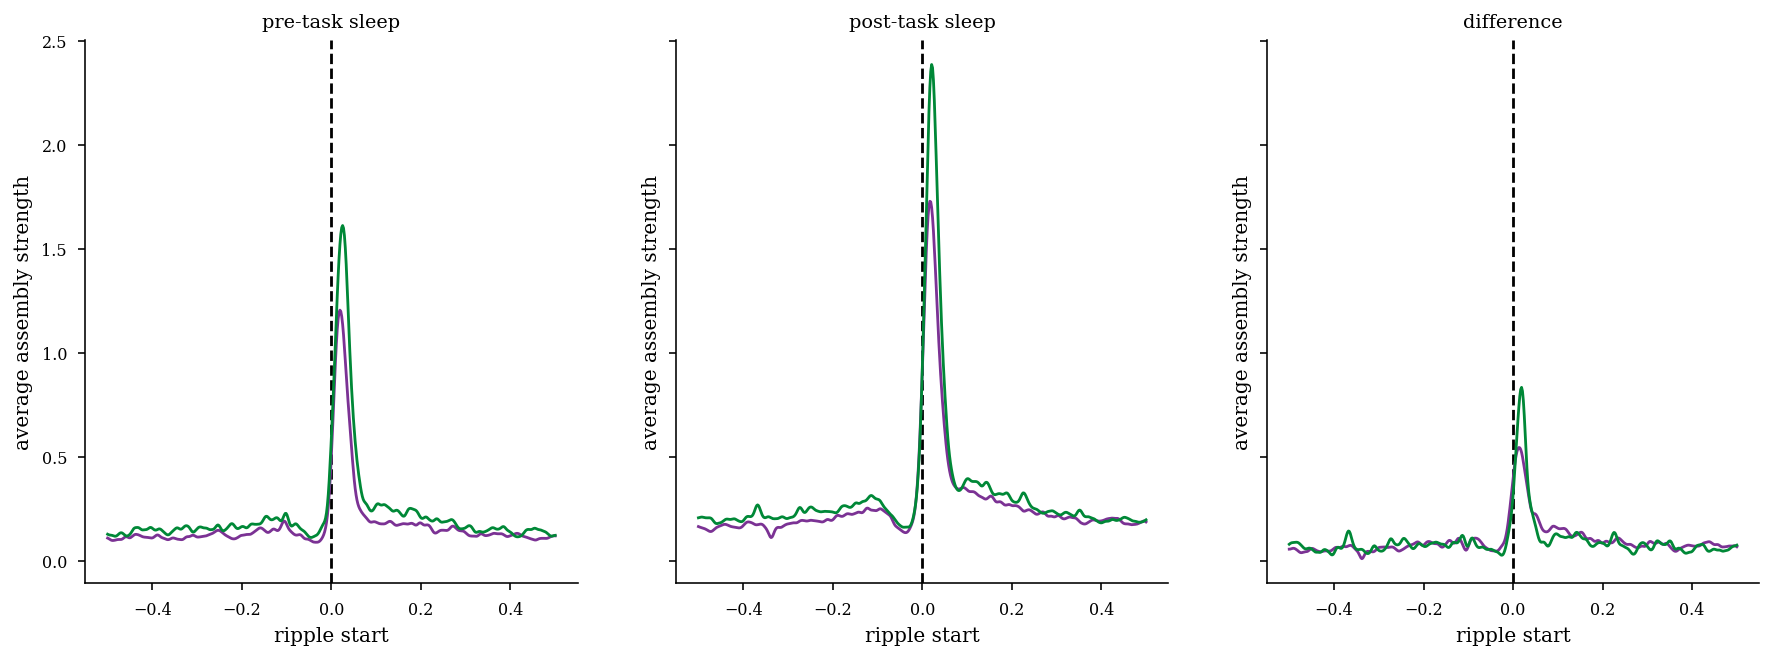

In [239]:
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}

titles = ["pre-task sleep", "post-task sleep", "difference"]

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
pre_idx = (results_df.epoch == "pre").values
post_idx = (results_df.epoch == "post").values
deep_idx = (results_df.deepSuperficial == "Deep").values
sup_idx = (results_df.deepSuperficial == "Superficial").values

ax[0].plot(
    peth.index,
    peth.iloc[ :, pre_idx & deep_idx].mean(axis=1),
    color=group_colors["Deep"],
)
ax[1].plot(
    peth.index,
    peth.iloc[ :, post_idx & deep_idx].mean(axis=1),
    color=group_colors["Deep"],
)
ax[2].plot(
    peth.index,
    peth.iloc[ :, post_idx & deep_idx].mean(axis=1).values - peth.iloc[ :, pre_idx & deep_idx].mean(axis=1).values,
    color=group_colors["Deep"],
)

ax[0].plot(
    peth.index,
    peth.iloc[ :, pre_idx & sup_idx].mean(axis=1),
    color=group_colors["Superficial"],
)
ax[1].plot(
    peth.index,
    peth.iloc[ :, post_idx & sup_idx].mean(axis=1),
    color=group_colors["Superficial"],
)
ax[2].plot(
    peth.index,
    peth.iloc[ :, post_idx & sup_idx].mean(axis=1).values - peth.iloc[ :, pre_idx & sup_idx].mean(axis=1).values,
    color=group_colors["Superficial"],
)

for i, title in enumerate(titles):
    ax[i].set_title(title)
    ax[i].set_xlabel("ripple start")
    ax[i].set_ylabel("average assembly strength")
    ax[i].axvline(0,color="k",linestyle="--",zorder=-100)
    # ax[i].axvline(0.05,color="k",linestyle="--",zorder=-100)

sns.despine()
plt.show()


In [259]:
peth.iloc[ :, post_idx & sup_idx].values.T.shape

(304, 500)

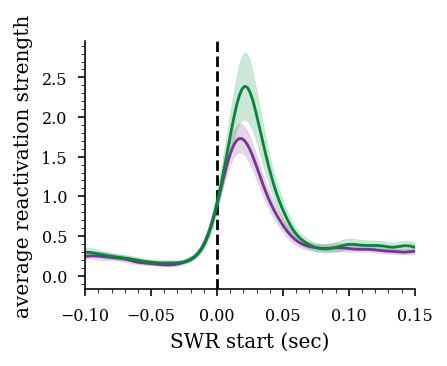

In [363]:
fig= plt.figure(figsize=functions.set_size("thesis", fraction=.5, subplots=(1.25,1)), edgecolor=None)
ax = plt.gca()

ax.plot(
    peth.index,
    peth.iloc[ :, post_idx & deep_idx].mean(axis=1),
    color=group_colors["Deep"],
)
lower, upper = functions.confidence_intervals(peth.iloc[ :, post_idx & deep_idx].values.T)
ax.fill_between(peth.index, lower, upper,color=group_colors["Deep"],alpha=.2)

ax.plot(
    peth.index,
    peth.iloc[ :, post_idx & sup_idx].mean(axis=1),
    color=group_colors["Superficial"],
)
lower, upper = functions.confidence_intervals(peth.iloc[ :, post_idx & sup_idx].values.T)
ax.fill_between(peth.index, lower, upper,color=group_colors["Superficial"],alpha=.2)

ax.set_xlim(-.1,.15)

ax.set_xlabel("SWR start (sec)")
ax.set_ylabel("average reactivation strength")
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.axvline(0,color="k",linestyle="--",zorder=-100)

sns.despine()

plt.savefig(
    os.path.join(fig_save_path, "post_task_reactivation_deep_sup.svg"),
    dpi=300,
    bbox_inches="tight",
)

In [277]:
results_df["response_50ms"] = peth[(peth.index > 0) & (peth.index < 0.05)].mean(axis=0).values
results_df["response_50ms_peak"] = peth[(peth.index > 0) & (peth.index < 0.05)].max(axis=0).values


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Deep vs. Superficial: Mann-Whitney-Wilcoxon test two-sided, P_val:2.367e-02 U_stat=8.744e+04


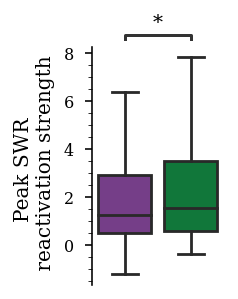

In [360]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
sns.boxplot(
    y="response_50ms_peak",
    x="deepSuperficial",
    data=results_df.query("epoch=='post'"),
    showfliers=False,
)
plt.ylabel("Peak SWR \n reactivation strength")

ax = plt.gca()
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.set_xlabel("")
# ax.legend("")

box_pairs = [
("Deep", "Superficial"),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=results_df.query("epoch=='post'"),
    x="deepSuperficial",
    y="response_50ms_peak",
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()

plt.savefig(
    os.path.join(fig_save_path, "post_task_reactivation_peak_compare_deep_sup.svg"),
    dpi=300,
    bbox_inches="tight",
)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Deep vs. Superficial: t-test independent samples, P_val:6.460e-03 t=-2.730e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Deep vs. Superficial: t-test independent samples, P_val:1.834e-03 t=-3.125e+00


(<AxesSubplot:xlabel='deepSuperficial', ylabel='response_50ms'>,
 [<statannotations.Annotation.Annotation at 0x1e32026e0d0>])

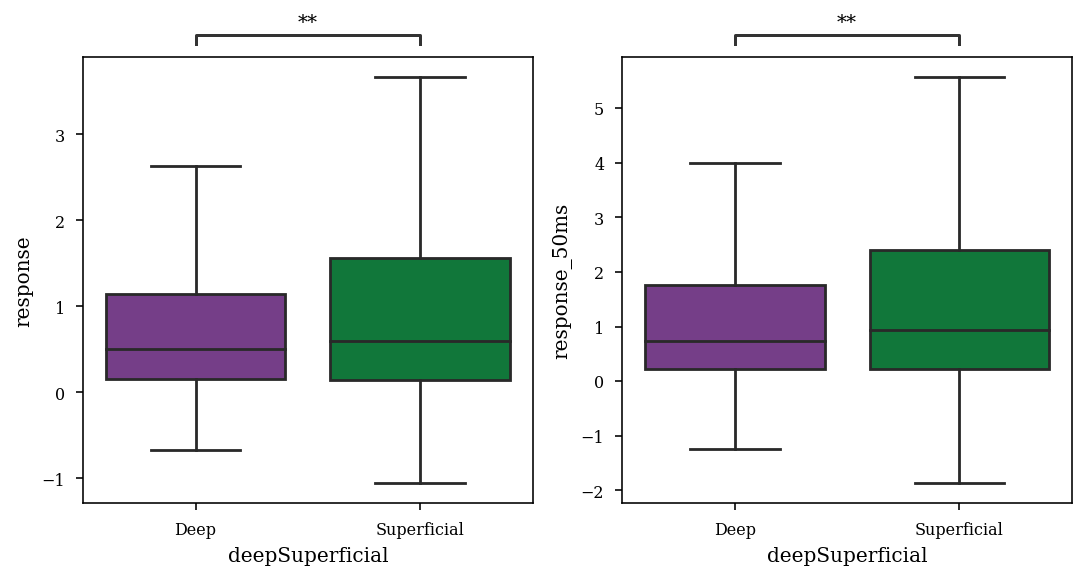

In [234]:
fig, ax = plt.subplots(1,2,figsize=functions.set_size("thesis", fraction=1.5, subplots=(1.5, 2)), edgecolor=None,sharey=False)

sns.boxplot(
    y="response",
    x="deepSuperficial",
    data=results_df.query("epoch=='post'"),
    showfliers=False,
    ax=ax[0]
)
box_pairs = [
("Deep", "Superficial"),
]
annotator = Annotator(
    ax[0],
    box_pairs,
    data=results_df.query("epoch=='post'"),
    x="deepSuperficial",
    y="response",
)
annotator.configure(
    test="t-test_ind",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()
# plt.show()


sns.boxplot(
    y="response_50ms",
    x="deepSuperficial",
    data=results_df.query("epoch=='post'"),
    showfliers=False,
    ax=ax[1]
)
box_pairs = [
("Deep", "Superficial"),
]
annotator = Annotator(
    ax[1],
    box_pairs,
    data=results_df.query("epoch=='post'"),
    x="deepSuperficial",
    y="response_50ms",
)
annotator.configure(
    test="t-test_ind",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()

## show paired plot

In [185]:
results_df["unique_id"] = (
    results_df.assembly_n.astype(str) + results_df.deepSuperficial + results_df.basepath
)

### remove rows with nan


In [198]:
for unique_id in results_df.query("response.isnull() | response_50ms.isnull()").unique_id.unique():
    results_df.loc[results_df.unique_id == unique_id,"response"] = np.nan
    results_df.loc[results_df.unique_id == unique_id,"response_50ms"] = np.nan

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post: t-test paired samples, P_val:1.930e-10 t=-6.474e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post: t-test paired samples, P_val:1.102e-05 t=-4.473e+00


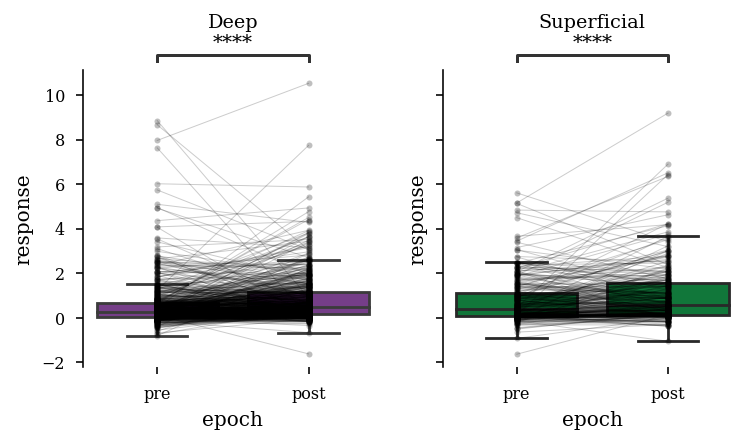

In [199]:
fig, ax = plt.subplots(1,2,
    figsize=functions.set_size("thesis", fraction=1, subplots=(1.5, 2)), edgecolor=None,sharey=True
)
fig.subplots_adjust(wspace=0.2)
ax = ax.ravel()
group = results_df.deepSuperficial.unique()
for i , g in enumerate(group): 

    sns.boxplot(
        y="response",
        x="epoch",
        data=results_df.query("deepSuperficial==@g"),
        color = group_colors[g],
        showfliers=False,
        ax=ax[i],
    )
    sns.stripplot(
        y="response",
        x="epoch",
        data=results_df.query("deepSuperficial==@g"),
        color="k",
        jitter=False,
        alpha=.25,
        size=3,
        ax=ax[i],
    )
    sns.lineplot(
        y="response",
        x="epoch",
        data=results_df.query("deepSuperficial==@g"),
        units="unique_id",
        estimator=None,
        color="k",
        alpha=0.2,
        lw=.5,
        legend=True,
        zorder = 1000,
        ax=ax[i]
    )
    sns.despine(bottom=True)
    
    ax[i].set_title(g,y=1.1)

    box_pairs = [
    ("pre", "post"),
    ]
    annotator = Annotator(
        ax[i],
        box_pairs,
        data=results_df.query("deepSuperficial==@g"),
        x="epoch",
        y="response",
    )
    annotator.configure(
        test="t-test_paired",
        text_format="star",
        loc="outside",
        comparisons_correction=None,
        verbose=1,
    )
    annotator.apply_and_annotate()

    # ax[i].set_xticklabels(['base','test'])
    # ax[i].set_xlabel('')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post: t-test paired samples, P_val:1.372e-08 t=-5.753e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post: t-test paired samples, P_val:7.985e-06 t=-4.546e+00


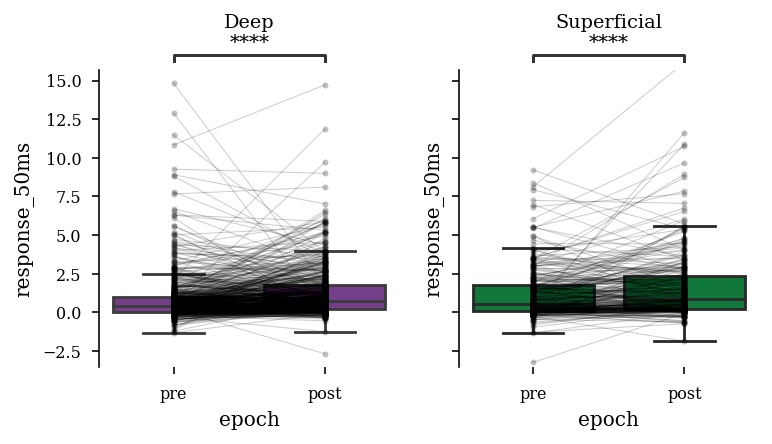

In [200]:
fig, ax = plt.subplots(1,2,
    figsize=functions.set_size("thesis", fraction=1, subplots=(1.5, 2)), edgecolor=None,sharey=True
)
fig.subplots_adjust(wspace=0.2)
ax = ax.ravel()
group = results_df.deepSuperficial.unique()
for i , g in enumerate(group): 

    sns.boxplot(
        y="response_50ms",
        x="epoch",
        data=results_df.query("deepSuperficial==@g"),
        color = group_colors[g],
        showfliers=False,
        ax=ax[i],
    )
    sns.stripplot(
        y="response_50ms",
        x="epoch",
        data=results_df.query("deepSuperficial==@g"),
        color="k",
        jitter=False,
        alpha=.25,
        size=3,
        ax=ax[i],
    )
    sns.lineplot(
        y="response_50ms",
        x="epoch",
        data=results_df.query("deepSuperficial==@g"),
        units="unique_id",
        estimator=None,
        color="k",
        alpha=0.2,
        lw=.5,
        legend=True,
        zorder = 1000,
        ax=ax[i]
    )
    sns.despine(bottom=True)
    
    ax[i].set_title(g,y=1.1)

    box_pairs = [
    ("pre", "post"),
    ]
    annotator = Annotator(
        ax[i],
        box_pairs,
        data=results_df.query("deepSuperficial==@g"),
        x="epoch",
        y="response_50ms",
    )
    annotator.configure(
        test="t-test_paired",
        text_format="star",
        loc="outside",
        comparisons_correction=None,
        verbose=1,
    )
    annotator.apply_and_annotate()

    # ax[i].set_xticklabels(['base','test'])
    # ax[i].set_xlabel('')

## difference plot

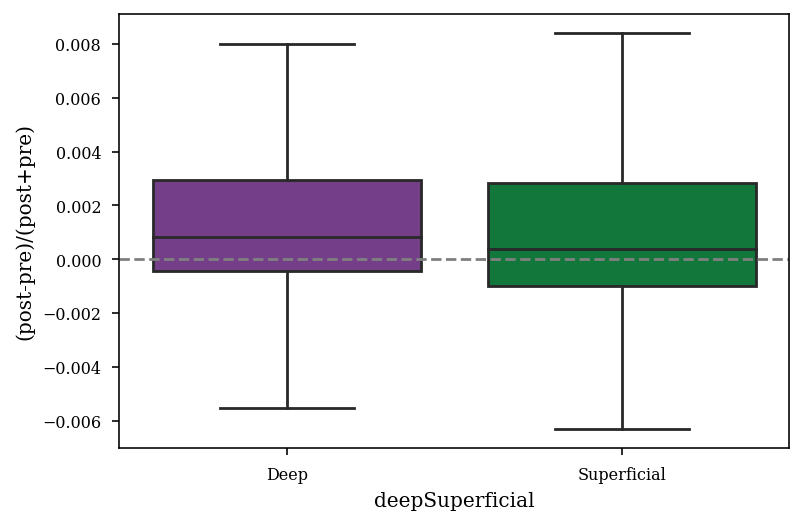

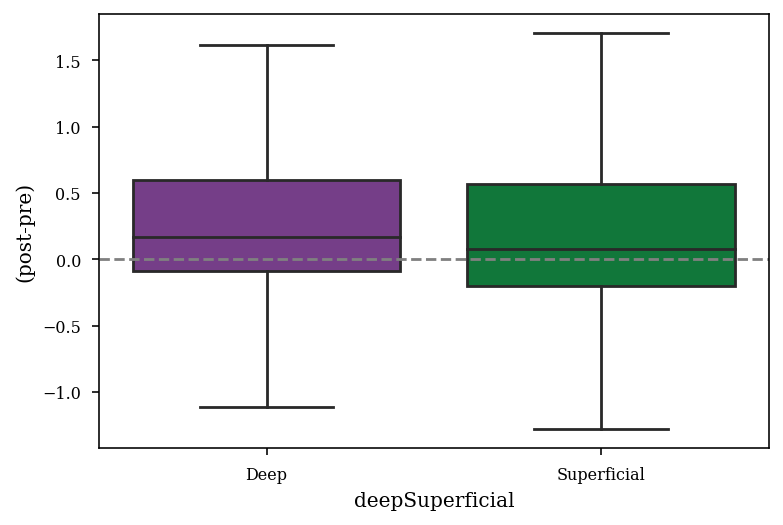

In [268]:
def ratio(a, b):
    return (a - b) / (a + b)

results_df_pivot = results_df.pivot(
    index=["basepath", "assembly_n", "deepSuperficial"],
    columns="epoch",
    values="response",
).reset_index()
results_df_pivot["(post-pre)/(post+pre)"] = ratio(results_df_pivot.post + 100, results_df_pivot.pre + 100)
results_df_pivot["(post-pre)"] = results_df_pivot.post - results_df_pivot.pre

group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(
    y="(post-pre)/(post+pre)",
    x="deepSuperficial",
    data=results_df_pivot,
    showfliers=False,
)
plt.axhline(0,linestyle="--",color="grey")
plt.show()

sns.boxplot(
    y="(post-pre)",
    x="deepSuperficial",
    data=results_df_pivot,
    showfliers=False,
)
plt.axhline(0,linestyle="--",color="grey")
plt.show()


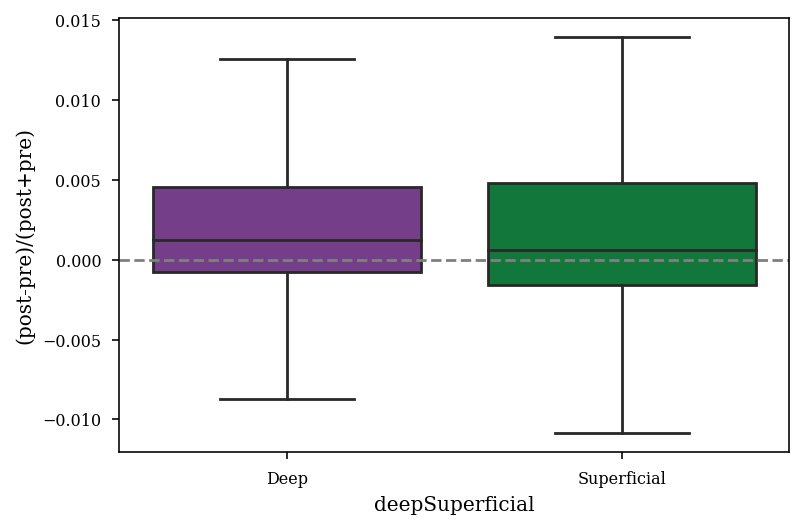

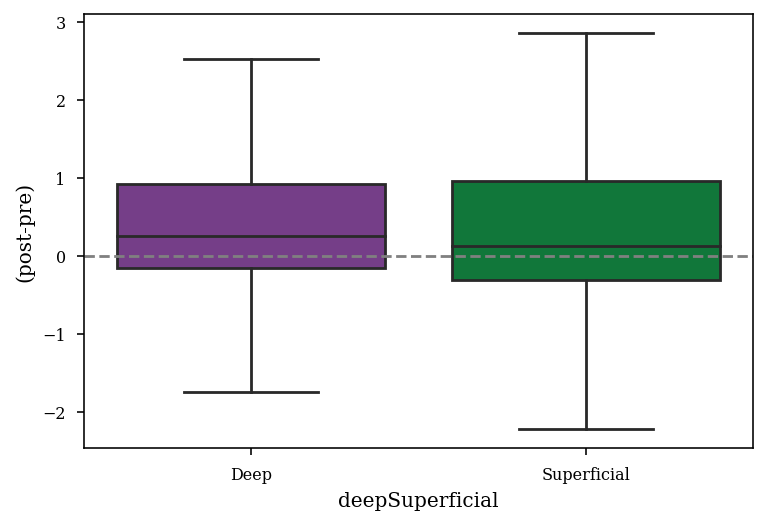

In [276]:
results_df_pivot = results_df.pivot(
    index=["basepath", "assembly_n", "deepSuperficial"],
    columns="epoch",
    values="response_50ms",
).reset_index()
results_df_pivot["(post-pre)/(post+pre)"] = ratio(results_df_pivot.post + 100, results_df_pivot.pre + 100)
results_df_pivot["(post-pre)"] = results_df_pivot.post - results_df_pivot.pre

group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(
    y="(post-pre)/(post+pre)",
    x="deepSuperficial",
    data=results_df_pivot,
    showfliers=False,
)
plt.axhline(0,linestyle="--",color="grey")
plt.show()

sns.boxplot(
    y="(post-pre)",
    x="deepSuperficial",
    data=results_df_pivot,
    showfliers=False,
)
# sns.stripplot(
#     y="(post-pre)",
#     x="deepSuperficial",
#     data=results_df_pivot,
#     color="k"
# )
plt.axhline(0,linestyle="--",color="grey")
plt.show()

In [326]:
results_df_pivot.post.min()

-1.192279292043217

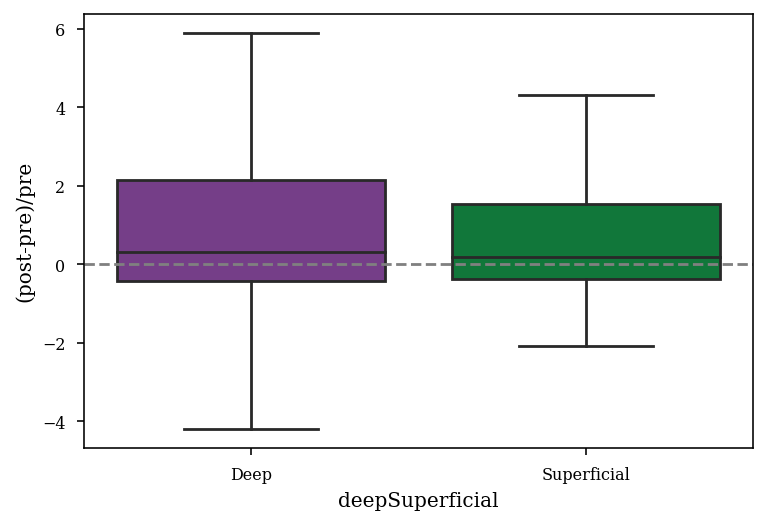

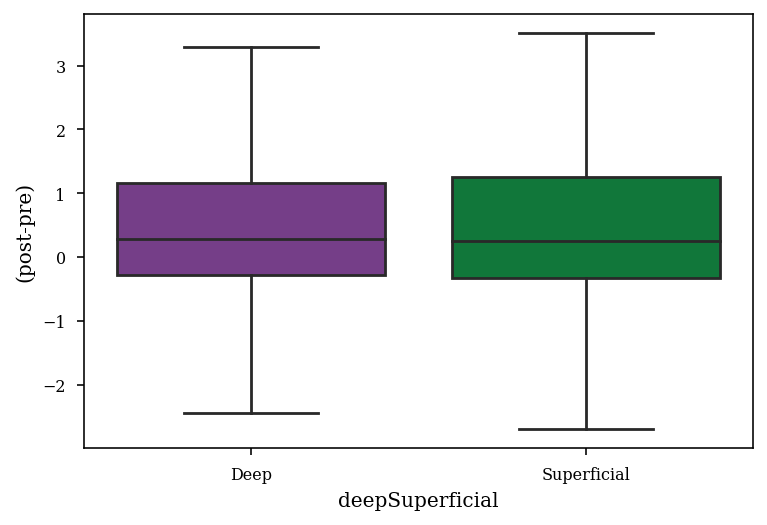

In [335]:
def ratio(a, b):
    return (a - b) / b

results_df_pivot = results_df.pivot(
    index=["basepath", "assembly_n", "deepSuperficial"],
    columns="epoch",
    values="response_50ms_peak",
).reset_index()
results_df_pivot["(post-pre)/pre"] = ratio(results_df_pivot.post, results_df_pivot.pre)
results_df_pivot["(post-pre)"] = (results_df_pivot.post + 10) - (results_df_pivot.pre + 10)

group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(
    y="(post-pre)/pre",
    x="deepSuperficial",
    data=results_df_pivot,
    showfliers=False,
)
plt.axhline(0,linestyle="--",color="grey")
plt.show()

sns.boxplot(
    y="(post-pre)",
    x="deepSuperficial",
    data=results_df_pivot,
    showfliers=False,
)
# sns.barplot(
#     y="(post-pre)",
#     x="deepSuperficial",
#     data=results_df_pivot,
#     errorbar=("se")
# )
# sns.stripplot(
#     y="(post-pre)",
#     x="deepSuperficial",
#     data=results_df_pivot,
#     color="k"
# )
# plt.yscale("log")
# plt.axhline(0,linestyle="--",color="grey")
plt.show()

<AxesSubplot:xlabel='deepSuperficial', ylabel='(post-pre)'>

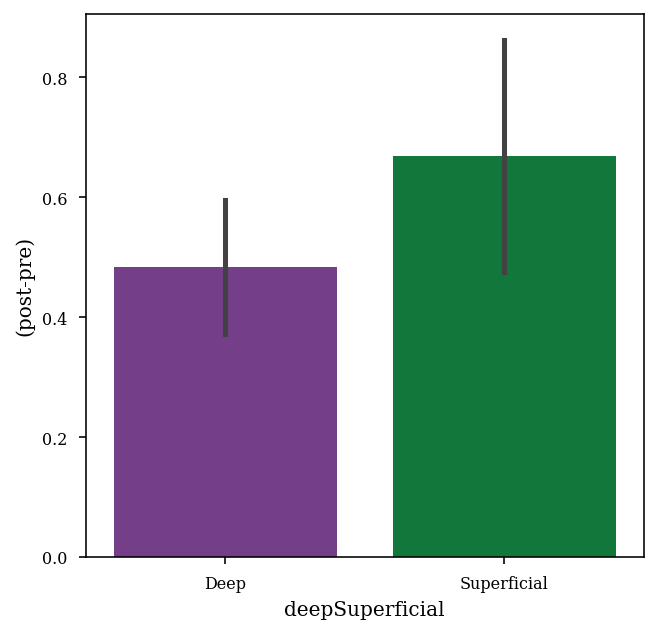

In [320]:
plt.figure(figsize=(5,5))
sns.barplot(
    y="(post-pre)",
    x="deepSuperficial",
    data=results_df_pivot,
    errorbar=("se")
)
# plt.ylim(-2,2)

## testing below

In [3]:
m1 = assembly_reactivation.AssemblyReact(basepath=r"Z:\Data\HMC2\day5")

m1.load_data()
m1.get_weights(epoch=m1.epochs[1])
assembly_act_pre = m1.get_assembly_act(epoch=m1.epochs[0])
assembly_act_post = m1.get_assembly_act(epoch=m1.epochs[2])

peth_avg_pre, time_lags = functions.event_triggered_average(
    assembly_act_pre.abscissa_vals,
    assembly_act_pre.data.T,
    m1.ripples[m1.epochs[0]].starts,
    window=[-0.5, 0.5],
)
peth_avg_post, time_lags = functions.event_triggered_average(
    assembly_act_post.abscissa_vals,
    assembly_act_post.data.T,
    m1.ripples[m1.epochs[2]].starts,
    window=[-0.5, 0.5],
)

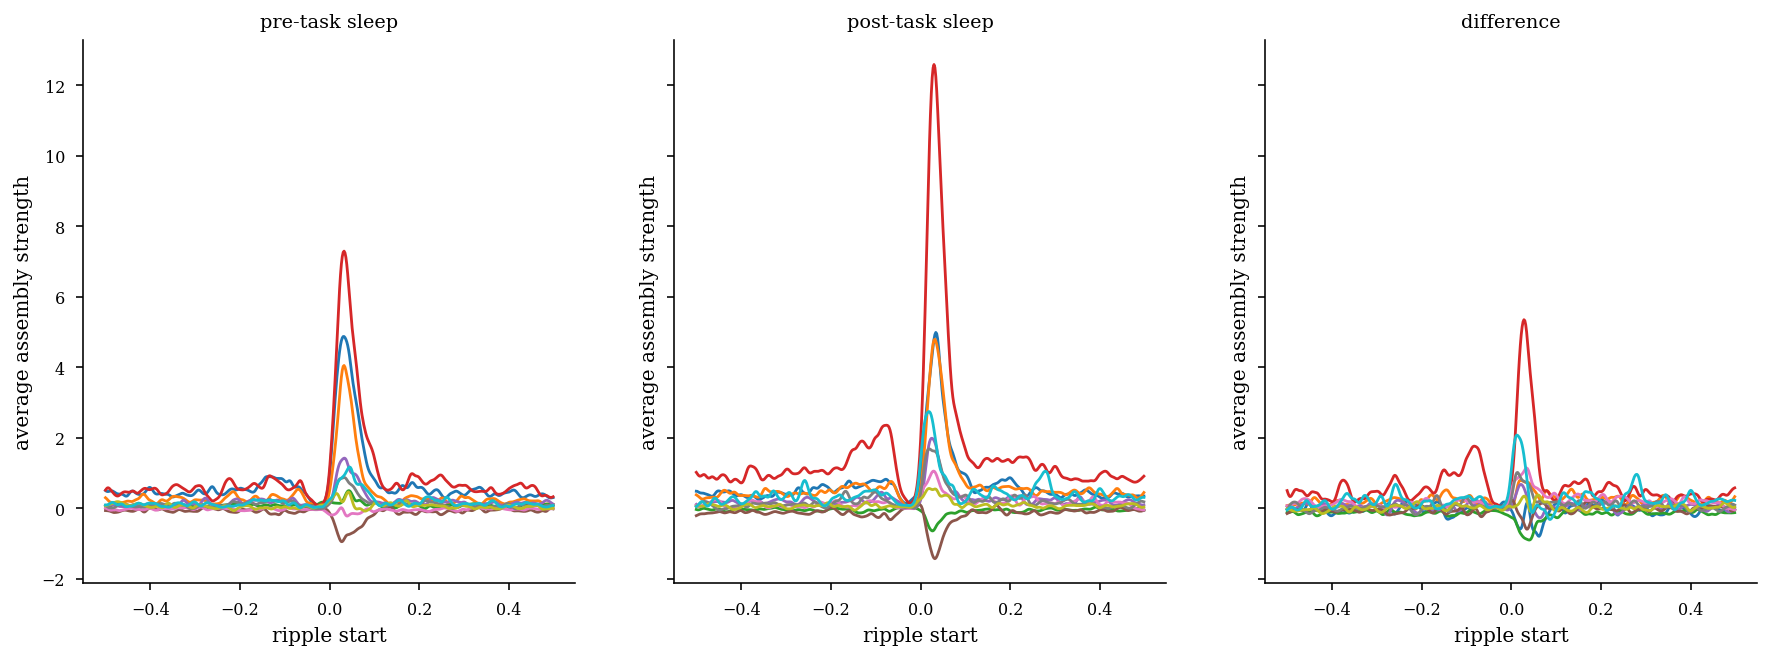

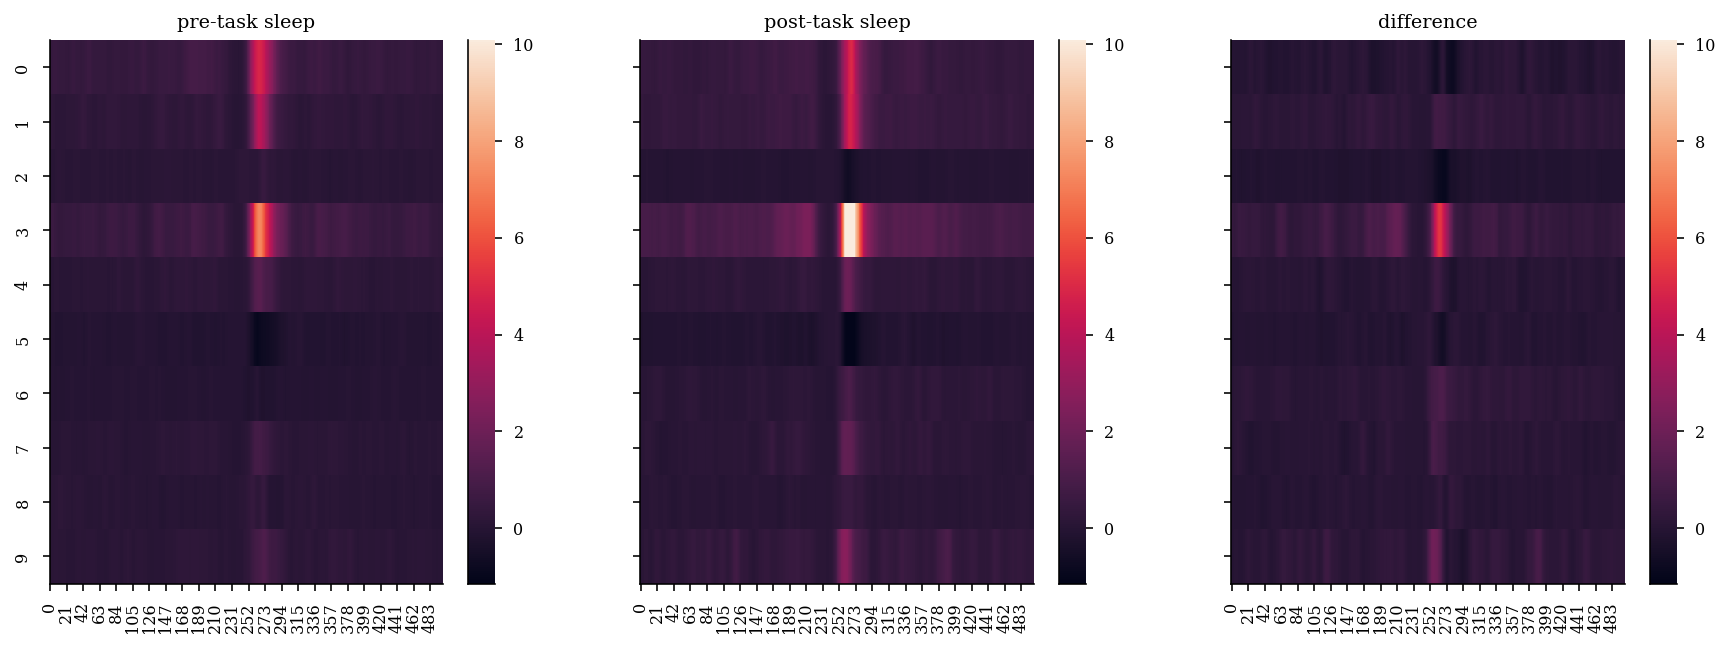

In [7]:
titles = ['pre-task sleep','post-task sleep','difference']

fig,ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
ax[0].plot(time_lags,peth_avg_pre)
ax[1].plot(time_lags,peth_avg_post)
ax[2].plot(time_lags,peth_avg_post-peth_avg_pre)
for i,title in enumerate(titles):
    ax[i].set_title(title)
    ax[i].set_xlabel("ripple start")
    ax[i].set_ylabel("average assembly strength")
sns.despine()
plt.show()

fig,ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
vmax = np.nanmax([peth_avg_post,peth_avg_pre])*.8
vmin = np.nanmin([peth_avg_post,peth_avg_pre])*.8

sns.heatmap(peth_avg_pre.T,ax=ax[0],vmax=vmax,vmin=vmin)
sns.heatmap(peth_avg_post.T,ax=ax[1],vmax=vmax,vmin=vmin)
sns.heatmap((peth_avg_post-peth_avg_pre).T,ax=ax[2],vmax=vmax,vmin=vmin)
for i,title in enumerate(titles):
    ax[i].set_title(title)
sns.despine()
plt.show()

In [24]:
peth_avg_pre.shape

(500, 10)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post: t-test paired samples, P_val:1.449e-01 t=-1.596e+00


(<AxesSubplot:xlabel='epoch', ylabel='response'>,
 [<statannotations.Annotation.Annotation at 0x202cedb2af0>])

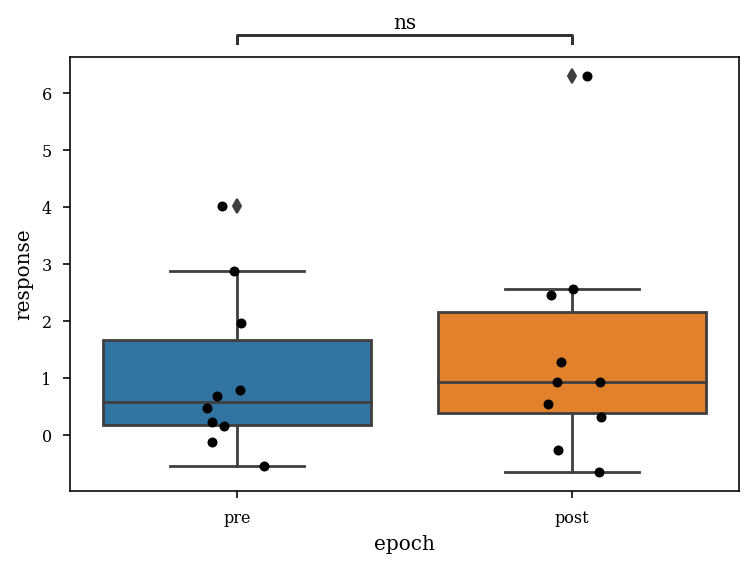

In [37]:
# define the mean response to ripples as the strength between 0 and 100ms after the ripple start
response_df = pd.DataFrame()
response_df["response"] = np.hstack(
    [
        np.mean(peth_avg_pre[(time_lags > 0) & (time_lags < 0.1), :], axis=0),
        np.mean(peth_avg_post[(time_lags > 0) & (time_lags < 0.1), :], axis=0),
    ]
)
# add labels for epochs
response_df["epoch"] = np.hstack(
    [["pre"] * peth_avg_pre.shape[1], ["post"] * peth_avg_pre.shape[1]]
)
response_df

sns.boxplot(data=response_df, x="epoch", y="response")
sns.stripplot(data=response_df, x="epoch", y="response", color="k")

box_pairs = [
    ("pre", "post"),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=response_df,
    x="epoch",
    y="response",
)
annotator.configure(
    test="t-test_paired",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()
